In [2]:
import torch
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.calibration import calibration_curve

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from Model.data import DataModule
from Model.network import Model
from Configs.config import config
from Utils.logger import Logger

pd.set_option('display.max_columns', 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computational Device: {device}")
print(f"Target Variables: {config.columns.target_cols}")

Computational Device: cuda
Target Variables: ['target_short', 'target_medium', 'target_long']


In [4]:
project_root = os.getcwd()
data_path = os.path.join(project_root, config.paths.train_data)
runs_dir = os.path.join(project_root, "Runs")
available_runs = sorted(os.listdir(runs_dir))

for run in reversed(available_runs):
    checkpoint_path = os.path.join(runs_dir, run, "checkpoints", "best_model.pth")
    if os.path.exists(checkpoint_path):
        latest_run = run
        break

ema_checkpoint_path = os.path.join(runs_dir, latest_run, "checkpoints", "best_model_ema.pth")
use_ema = os.path.exists(ema_checkpoint_path)

print(f"Experiment Run: {latest_run}")
print(f"Checkpoint Path: {checkpoint_path}")
print(f"EMA Model: {'Available' if use_ema else 'Not Available'}")

Experiment Run: 20260120_235830
Checkpoint Path: /root/rental-churn/Runs/20260120_235830/checkpoints/best_model.pth
EMA Model: Available


In [5]:
logger = Logger(log_dir="logs", name="ResultsAnalysis", level="INFO", enable_tensorboard=False)

dm = DataModule(
    data_path,
    batch_size=config.model.batch_size,
    num_workers=0,
    pin_memory=False,
    logger=logger,
    max_sequence_length=config.model.max_seq_len,
    min_sequence_length=config.data.min_sequence_length
)
dm.prepare_data()

print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"Training samples:   {len(dm.train_indices):,}")
print(f"Validation samples: {len(dm.validation_indices):,}")
print(f"Test samples:       {len(dm.test_indices):,}")
print(f"Total samples:      {len(dm.train_indices) + len(dm.validation_indices) + len(dm.test_indices):,}")
print(f"\nFeature Dimensions:")
print(f"  Categorical features: {len(dm.categorical_columns)}")
print(f"  Continuous features:  {len(dm.continuous_columns)}")
print(f"  Target variables:     {len(dm.target_columns)} ({', '.join(dm.target_columns)})")

[00:53:25] [Experiment] ResultsAnalysis
[00:53:25] [Start] 2026-01-21 00:53:25
[00:53:25] [Log Dir] /root/rental-churn/logs
[00:53:25] 
[00:53:25] >>> DATA PREPARATION PIPELINE
[00:53:25] [Data Loading] Loading sequential data from: /root/rental-churn/Data/training_data.parquet
[00:53:36] [Data Loading] Loaded 5,991,050 rows, 132 columns
[00:53:36] [Data Cleaning] Removing 109,204 users with missing payment dates (NaT)
[00:53:51]   > Feature Configuration
[00:53:51] [Features] Categorical: 17 features
[00:53:51] [Features] Continuous: 26 features
[00:53:51] [Features] Targets: 3 (target_short, target_medium, target_long)
[00:54:42] [Stratified Sampling] Users with target_long (>14d): 4,439
[00:54:42] [Stratified Sampling] Users with target_medium only (7-14d): 12,186
[00:54:42] [Stratified Sampling] Users with target_short only (3-7d): 36,821
[00:54:42] [Stratified Sampling] Users with no defaults (<=3d): 99,679
[00:54:42] [Subsampling] Stratified sampling: 16,625/153,125 users (10.9%)

In [6]:
model = Model(
    embedding_dimensions=dm.embedding_dimensions,
    num_continuous=len(dm.continuous_columns),
    hidden_dimension=config.model.hidden_dim,
    num_invoice_layers=config.model.num_invoice_layers,
    num_sequence_layers=config.model.n_blocks,
    num_heads=config.model.n_heads,
    dropout=config.model.dropout,
    drop_path_rate=config.model.drop_path_rate,
    use_temporal_attention=config.model.use_temporal_attention,
    use_temperature_scaling=config.model.use_temperature_scaling,
    max_sequence_length=config.model.max_seq_len
).to(device)

model_path = ema_checkpoint_path if use_ema else checkpoint_path
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
elif 'ema_state_dict' in checkpoint:
    state_dict = checkpoint['ema_state_dict']
else:
    state_dict = checkpoint
    
model.load_state_dict(state_dict)
model.eval()

n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{'='*60}")
print(f"MODEL ARCHITECTURE")
print(f"{'='*60}")
print(f"Model variant:        {'EMA' if use_ema else 'Standard'}")
print(f"Total parameters:     {n_params:,}")
print(f"Trainable parameters: {n_trainable:,}")
print(f"Temperature Scaling:  {'Enabled' if model.use_temperature_scaling else 'Disabled'}")

if 'epoch' in checkpoint:
    print(f"Training epochs:      {checkpoint['epoch']}")
if 'best_val_auc' in checkpoint:
    print(f"Best validation AUC:  {checkpoint['best_val_auc']:.4f}")

MODEL ARCHITECTURE
Model variant:        EMA
Total parameters:     1,777,734
Trainable parameters: 1,777,734
Temperature Scaling:  Enabled


In [7]:
all_logits, all_targets, all_lengths = [], [], []

with torch.no_grad():
    for x_cat, x_cont, y, lengths in dm.test_dataloader():
        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)
        lengths = lengths.to(device)
        
        logits = model(x_cat, x_cont, lengths, apply_temperature=True)
        
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
        all_lengths.extend(lengths.cpu().numpy())

logits_tensor = torch.cat(all_logits)
targets_tensor = torch.cat(all_targets)
probs_tensor = torch.sigmoid(logits_tensor)

y_prob = probs_tensor.numpy()
y_true = targets_tensor.numpy().astype(int)
seq_lengths = np.array(all_lengths)
target_names = config.columns.target_cols

print(f"{'='*70}")
print(f"TEST SET STATISTICS")
print(f"{'='*70}")
print(f"Total samples: {len(y_true):,}")
print(f"Sequence length - Min: {seq_lengths.min()}, Max: {seq_lengths.max()}, Mean: {seq_lengths.mean():.1f}")
print(f"\nTarget Distribution:")
for i, name in enumerate(target_names):
    count = y_true[:, i].sum()
    pct = y_true[:, i].mean() * 100
    print(f"  {name}: {count:,} ({pct:.2f}%)")

TEST SET STATISTICS
Total samples: 26,644
Sequence length - Min: 1, Max: 50, Mean: 19.8

Target Distribution:
  target_short: 11,058 (41.50%)
  target_medium: 2,435 (9.14%)
  target_long: 329 (1.23%)


In [8]:
optimal_thresholds = {}
metrics_per_target = {}

for i, name in enumerate(target_names):
    y_t = y_true[:, i]
    y_p = y_prob[:, i]
    
    precisions, recalls, thresholds = precision_recall_curve(y_t, y_p)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    optimal_thresholds[name] = optimal_threshold
    
    y_pred = (y_p >= optimal_threshold).astype(int)
    
    auc_roc = roc_auc_score(y_t, y_p)
    auc_pr = average_precision_score(y_t, y_p)
    
    cm = confusion_matrix(y_t, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_per_target[name] = {
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'threshold': optimal_threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

print("="*80)
print("MULTI-TARGET PERFORMANCE METRICS")
print("="*80)
print(f"{'Target':<15} {'ROC-AUC':>10} {'PR-AUC':>10} {'Threshold':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-"*80)
for name in target_names:
    m = metrics_per_target[name]
    print(f"{name:<15} {m['auc_roc']:>10.4f} {m['auc_pr']:>10.4f} {m['threshold']:>10.3f} {m['precision']:>10.2%} {m['recall']:>10.2%} {m['f1']:>10.3f}")
print("-"*80)

avg_auc = np.mean([m['auc_roc'] for m in metrics_per_target.values()])
avg_pr = np.mean([m['auc_pr'] for m in metrics_per_target.values()])
print(f"{'AVERAGE':<15} {avg_auc:>10.4f} {avg_pr:>10.4f}")

MULTI-TARGET PERFORMANCE METRICS
Target             ROC-AUC     PR-AUC  Threshold  Precision     Recall         F1
--------------------------------------------------------------------------------
target_short        0.8405     0.7732      0.543     65.41%     82.70%      0.730
target_medium       0.8383     0.3374      0.518     32.32%     58.48%      0.416
target_long         0.7853     0.0421      0.443      6.72%     24.62%      0.106
--------------------------------------------------------------------------------
AVERAGE             0.8214     0.3842


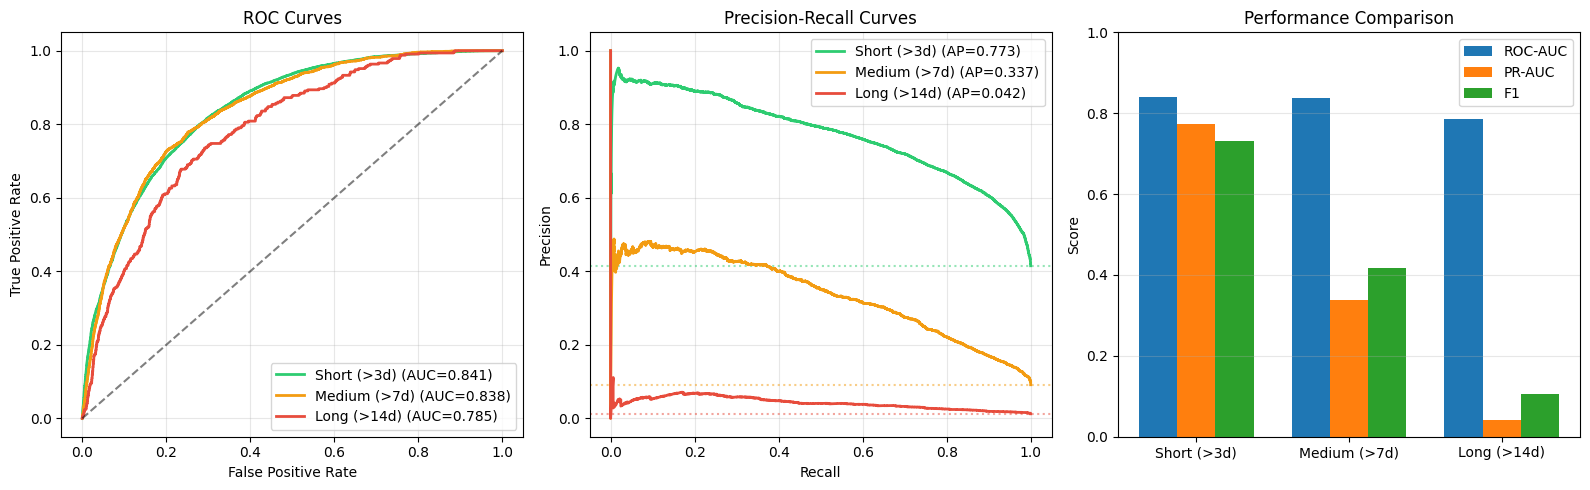

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = ['#2ecc71', '#f39c12', '#e74c3c']
labels = ['Short (>3d)', 'Medium (>7d)', 'Long (>14d)']

ax1 = axes[0]
for i, (name, color, label) in enumerate(zip(target_names, colors, labels)):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
    auc = metrics_per_target[name]['auc_roc']
    ax1.plot(fpr, tpr, color=color, linewidth=2, label=f'{label} (AUC={auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
for i, (name, color, label) in enumerate(zip(target_names, colors, labels)):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
    auc = metrics_per_target[name]['auc_pr']
    baseline = y_true[:, i].mean()
    ax2.plot(recall, precision, color=color, linewidth=2, label=f'{label} (AP={auc:.3f})')
    ax2.axhline(y=baseline, color=color, linestyle=':', alpha=0.5)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
x = np.arange(len(target_names))
width = 0.25
metrics_to_plot = ['auc_roc', 'auc_pr', 'f1']
metric_labels = ['ROC-AUC', 'PR-AUC', 'F1']

for j, (metric, mlabel) in enumerate(zip(metrics_to_plot, metric_labels)):
    values = [metrics_per_target[name][metric] for name in target_names]
    ax3.bar(x + j*width, values, width, label=mlabel)

ax3.set_ylabel('Score')
ax3.set_title('Performance Comparison')
ax3.set_xticks(x + width)
ax3.set_xticklabels(labels)
ax3.legend()
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/roc_pr_curves.pdf', dpi=300, bbox_inches='tight')
plt.show()

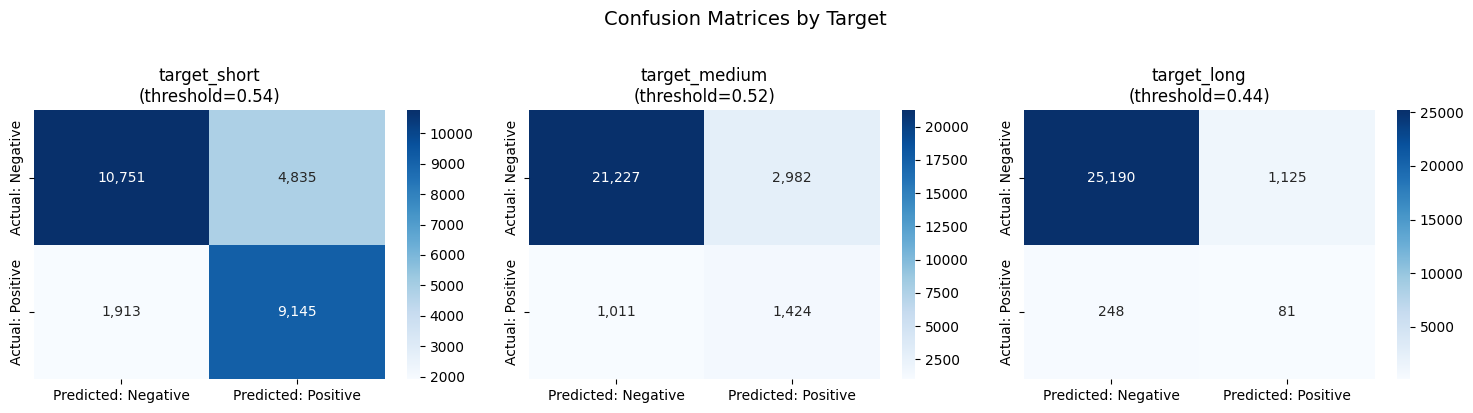

CLASSIFICATION OUTCOME ANALYSIS

TARGET_SHORT:
  True Negatives:  10,751 (40.4%)
  False Positives: 4,835 (18.1%)
  False Negatives: 1,913 (7.2%)
  True Positives:  9,145 (34.3%)

TARGET_MEDIUM:
  True Negatives:  21,227 (79.7%)
  False Positives: 2,982 (11.2%)
  False Negatives: 1,011 (3.8%)
  True Positives:  1,424 (5.3%)

TARGET_LONG:
  True Negatives:  25,190 (94.5%)
  False Positives: 1,125 (4.2%)
  False Negatives: 248 (0.9%)
  True Positives:  81 (0.3%)


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, ax) in enumerate(zip(target_names, axes)):
    m = metrics_per_target[name]
    cm = np.array([[m['tn'], m['fp']], [m['fn'], m['tp']]])
    
    sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=ax,
                xticklabels=['Predicted: Negative', 'Predicted: Positive'],
                yticklabels=['Actual: Negative', 'Actual: Positive'])
    ax.set_title(f"{name}\n(threshold={m['threshold']:.2f})")

plt.suptitle('Confusion Matrices by Target', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('figures/confusion_matrices.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("="*70)
print("CLASSIFICATION OUTCOME ANALYSIS")
print("="*70)
for name in target_names:
    m = metrics_per_target[name]
    total = m['tn'] + m['fp'] + m['fn'] + m['tp']
    print(f"\n{name.upper()}:")
    print(f"  True Negatives:  {m['tn']:,} ({m['tn']/total*100:.1f}%)")
    print(f"  False Positives: {m['fp']:,} ({m['fp']/total*100:.1f}%)")
    print(f"  False Negatives: {m['fn']:,} ({m['fn']/total*100:.1f}%)")
    print(f"  True Positives:  {m['tp']:,} ({m['tp']/total*100:.1f}%)")

ROC-AUC BY SEQUENCE LENGTH


,count,auc_target_short,auc_target_medium,auc_target_long
length_bin,,,,
1-2,3547,0.6764,0.7351,0.6357
3-5,4234,0.7882,0.7646,0.6670
6-10,4306,0.8229,0.7676,0.7412
11-20,4141,0.8686,0.7595,0.7319
21+,10416,0.8840,0.8140,0.7659


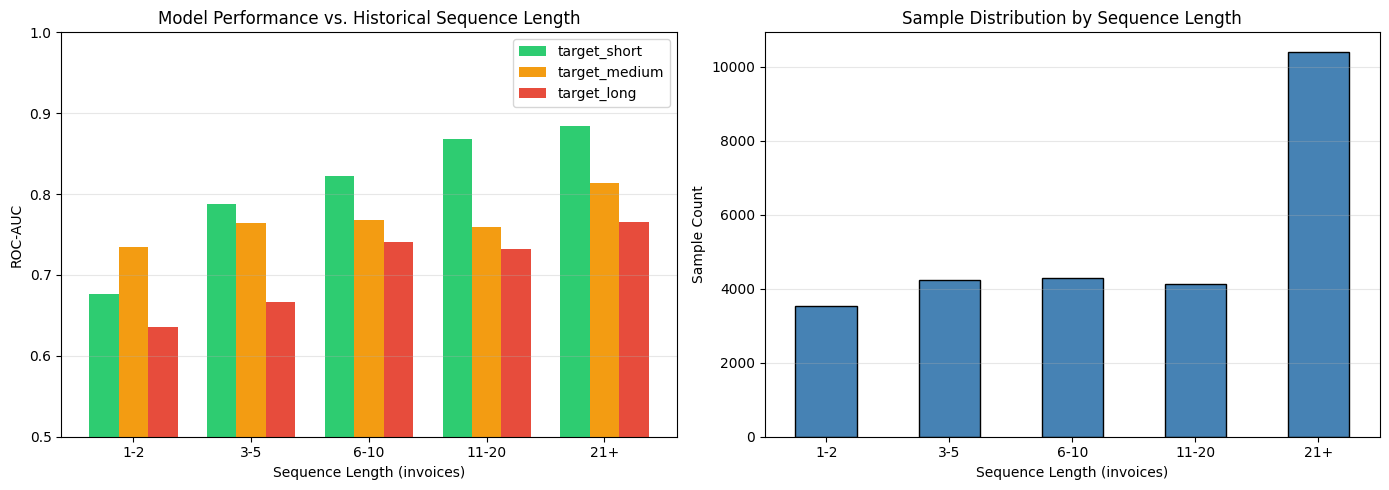

In [12]:
test_df = pd.DataFrame({
    'prob_short': y_prob[:, 0],
    'prob_medium': y_prob[:, 1],
    'prob_long': y_prob[:, 2],
    'target_short': y_true[:, 0],
    'target_medium': y_true[:, 1],
    'target_long': y_true[:, 2],
    'seq_length': seq_lengths
})

test_df['length_bin'] = pd.cut(test_df['seq_length'], 
                                bins=[0, 2, 5, 10, 20, 50],
                                labels=['1-2', '3-5', '6-10', '11-20', '21+'])

auc_by_length = []
for length_bin in test_df['length_bin'].dropna().unique():
    subset = test_df[test_df['length_bin'] == length_bin]
    if len(subset) < 10:
        continue
    
    row = {'length_bin': length_bin, 'count': len(subset)}
    for i, name in enumerate(target_names):
        y_t = subset[f'target_{name.split("_")[1]}'].values
        y_p = subset[f'prob_{name.split("_")[1]}'].values
        if len(np.unique(y_t)) > 1:
            row[f'auc_{name}'] = roc_auc_score(y_t, y_p)
        else:
            row[f'auc_{name}'] = np.nan
    auc_by_length.append(row)

length_analysis = pd.DataFrame(auc_by_length).set_index('length_bin')

print("="*80)
print("ROC-AUC BY SEQUENCE LENGTH")
print("="*80)
display(length_analysis.round(4))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
x = np.arange(len(length_analysis))
width = 0.25
for i, name in enumerate(target_names):
    col = f'auc_{name}'
    if col in length_analysis.columns:
        ax1.bar(x + i*width, length_analysis[col].values, width, label=name, color=colors[i])

ax1.set_xlabel('Sequence Length (invoices)')
ax1.set_ylabel('ROC-AUC')
ax1.set_title('Model Performance vs. Historical Sequence Length')
ax1.set_xticks(x + width)
ax1.set_xticklabels(length_analysis.index)
ax1.legend()
ax1.set_ylim(0.5, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[1]
length_analysis['count'].plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_xlabel('Sequence Length (invoices)')
ax2.set_ylabel('Sample Count')
ax2.set_title('Sample Distribution by Sequence Length')
plt.setp(ax2.get_xticklabels(), rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/performance_by_length.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
print("="*70)
print("THRESHOLD SENSITIVITY ANALYSIS - TARGET_LONG (>14 days)")
print("="*70)

target_idx = 2
y_t = y_true[:, target_idx]
y_p = y_prob[:, target_idx]

results = []
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    pred = (y_p >= threshold).astype(int)
    cm = confusion_matrix(y_t, pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'Threshold': f'{threshold:.0%}',
        'Recall': f'{recall:.1%}',
        'Precision': f'{precision:.1%}',
        'F1 Score': f'{f1:.3f}',
        'False Positives': f'{fp:,}',
        'False Negatives': f'{fn:,}'
    })

df_thresh = pd.DataFrame(results)
display(df_thresh)

print(f"\nOptimal thresholds (F1-maximizing):")
print(f"  target_long:   {optimal_thresholds['target_long']:.3f}")
print(f"  target_medium: {optimal_thresholds['target_medium']:.3f}")
print(f"  target_short:  {optimal_thresholds['target_short']:.3f}")

THRESHOLD SENSITIVITY ANALYSIS - TARGET_LONG (>14 days)


,Threshold,Recall,Precision,F1 Score,False Positives,False Negatives
0,10%,100.0%,1.2%,0.024,"26,315",0
1,20%,100.0%,1.2%,0.024,"26,315",0
2,30%,99.1%,1.5%,0.030,"20,792",3
3,40%,67.8%,3.5%,0.066,"6,209",106
4,50%,0.6%,5.1%,0.011,37,327
5,60%,0.0%,0.0%,0.000,14,329
6,70%,0.0%,0.0%,0.000,7,329
7,80%,0.0%,0.0%,0.000,0,329



Optimal thresholds (F1-maximizing):
  target_long:   0.443
  target_medium: 0.518
  target_short:  0.543


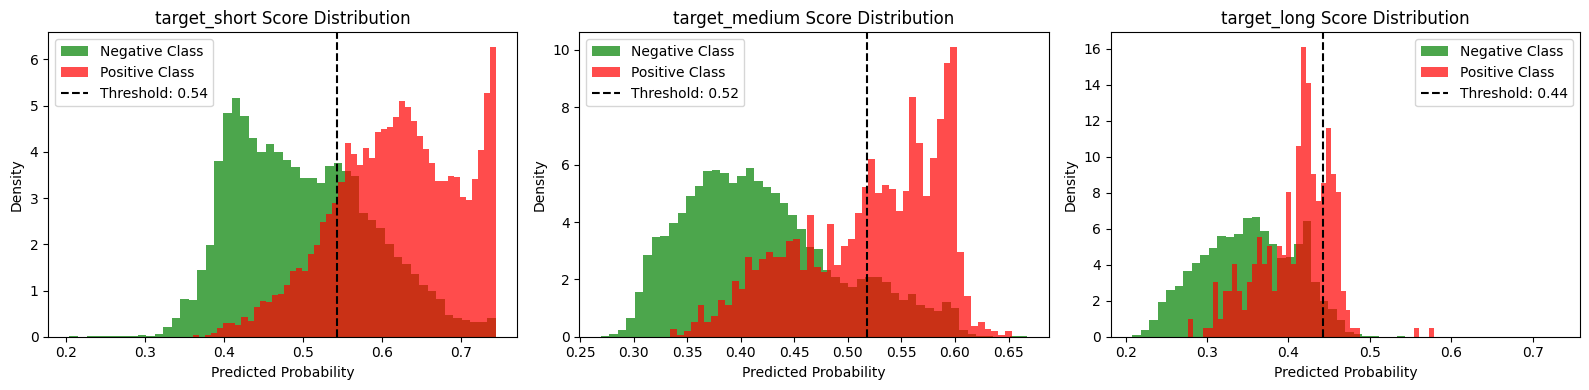


SCORE STATISTICS BY CLASS

TARGET_SHORT:
  Negative    : Mean=0.4993, Median=0.4895, Std=0.0860
  Positive    : Mean=0.6188, Median=0.6227, Std=0.0787

TARGET_MEDIUM:
  Negative    : Mean=0.4201, Median=0.4096, Std=0.0721
  Positive    : Mean=0.5203, Median=0.5327, Std=0.0662

TARGET_LONG:
  Negative    : Mean=0.3513, Median=0.3521, Std=0.0575
  Positive    : Mean=0.4090, Median=0.4181, Std=0.0441


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, (name, ax) in enumerate(zip(target_names, axes)):
    prob_col = f'prob_{name.split("_")[1]}'
    target_col = name
    
    no_default = test_df[test_df[target_col] == 0][prob_col]
    default = test_df[test_df[target_col] == 1][prob_col]
    
    ax.hist(no_default, bins=50, alpha=0.7, label='Negative Class', color='green', density=True)
    ax.hist(default, bins=50, alpha=0.7, label='Positive Class', color='red', density=True)
    ax.axvline(x=optimal_thresholds[name], color='black', linestyle='--', 
               label=f'Threshold: {optimal_thresholds[name]:.2f}')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Score Distribution')
    ax.legend()

plt.tight_layout()
plt.savefig('figures/score_distributions.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("SCORE STATISTICS BY CLASS")
print("="*70)
for name in target_names:
    prob_col = f'prob_{name.split("_")[1]}'
    target_col = name
    print(f"\n{name.upper()}:")
    for outcome, label in [(0, 'Negative'), (1, 'Positive')]:
        subset = test_df[test_df[target_col] == outcome][prob_col]
        print(f"  {label:12}: Mean={subset.mean():.4f}, Median={subset.median():.4f}, Std={subset.std():.4f}")

In [15]:
def create_risk_tiers(df, prob_col, target_col, n_tiers=10):
    df = df.copy()
    df['risk_tier'] = pd.qcut(df[prob_col], q=n_tiers, labels=False, duplicates='drop')
    df['risk_tier'] = df['risk_tier'] + 1
    return df

risk_df = create_risk_tiers(test_df, 'prob_long', 'target_long', n_tiers=10)

tier_analysis = risk_df.groupby('risk_tier').agg(
    count=('target_long', 'count'),
    defaults=('target_long', 'sum'),
    default_rate=('target_long', 'mean'),
    avg_score=('prob_long', 'mean'),
    avg_seq_len=('seq_length', 'mean'),
    min_score=('prob_long', 'min'),
    max_score=('prob_long', 'max')
).round(4)

tier_analysis['pct_of_total'] = (tier_analysis['count'] / len(risk_df) * 100).round(1)
tier_analysis['pct_of_defaults'] = (tier_analysis['defaults'] / risk_df['target_long'].sum() * 100).round(1)
tier_analysis['cumulative_defaults'] = tier_analysis['defaults'].iloc[::-1].cumsum().iloc[::-1]
tier_analysis['cumulative_pct'] = (tier_analysis['cumulative_defaults'] / risk_df['target_long'].sum() * 100).round(1)

print("="*90)
print("RISK STRATIFICATION ANALYSIS - TARGET_LONG")
print("="*90)
print("\nTier 10 = Highest Risk, Tier 1 = Lowest Risk")
print("-"*90)
display(tier_analysis[['count', 'defaults', 'default_rate', 'pct_of_defaults', 'cumulative_pct', 'min_score', 'max_score']])

RISK STRATIFICATION ANALYSIS - TARGET_LONG

Tier 10 = Highest Risk, Tier 1 = Lowest Risk
------------------------------------------------------------------------------------------


,count,defaults,default_rate,pct_of_defaults,cumulative_pct,min_score,max_score
risk_tier,,,,,,,
1,2665,0,0.0000,0.0,100.0,0.2078,0.2736
2,2664,3,0.0011,0.9,100.0,0.2737,0.2984
3,2664,9,0.0034,2.7,99.1,0.2984,0.3182
4,2665,17,0.0064,5.2,96.4,0.3182,0.3364
5,2664,13,0.0049,4.0,91.2,0.3364,0.3528
6,2664,22,0.0083,6.7,87.2,0.3528,0.3680
7,2665,23,0.0086,7.0,80.5,0.3681,0.3866
8,2664,42,0.0158,12.8,73.6,0.3866,0.4092
9,2664,71,0.0267,21.6,60.8,0.4092,0.4260


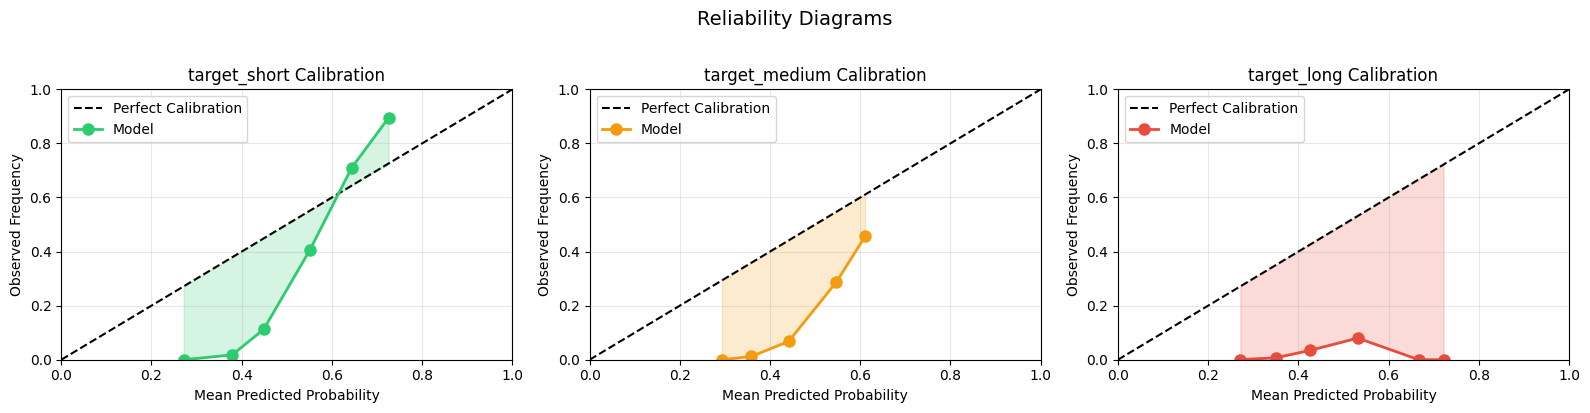


EXPECTED CALIBRATION ERROR (ECE)
target_short: ECE = 0.1954 (Poorly calibrated)
target_medium: ECE = 0.3378 (Poorly calibrated)
target_long: ECE = 0.3397 (Poorly calibrated)


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, (name, ax) in enumerate(zip(target_names, axes)):
    prob_col = f'prob_{name.split("_")[1]}'
    target_col = name
    
    y_t = test_df[target_col].values
    y_p = test_df[prob_col].values
    
    prob_true, prob_pred = calibration_curve(y_t, y_p, n_bins=10, strategy='uniform')
    
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    ax.plot(prob_pred, prob_true, 'o-', color=colors[i], linewidth=2, markersize=8, label='Model')
    ax.fill_between(prob_pred, prob_pred, prob_true, alpha=0.2, color=colors[i])
    
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_title(f'{name} Calibration')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.suptitle('Reliability Diagrams', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('figures/calibration_curves.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("EXPECTED CALIBRATION ERROR (ECE)")
print("="*70)

for name in target_names:
    prob_col = f'prob_{name.split("_")[1]}'
    target_col = name
    
    y_t = test_df[target_col].values
    y_p = test_df[prob_col].values
    
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    
    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        in_bin = (y_p > bin_lower) & (y_p <= bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            avg_confidence = y_p[in_bin].mean()
            avg_accuracy = y_t[in_bin].mean()
            ece += np.abs(avg_accuracy - avg_confidence) * prop_in_bin
    
    calibration_status = "Well calibrated" if ece < 0.05 else "Moderate" if ece < 0.1 else "Poorly calibrated"
    print(f"{name}: ECE = {ece:.4f} ({calibration_status})")

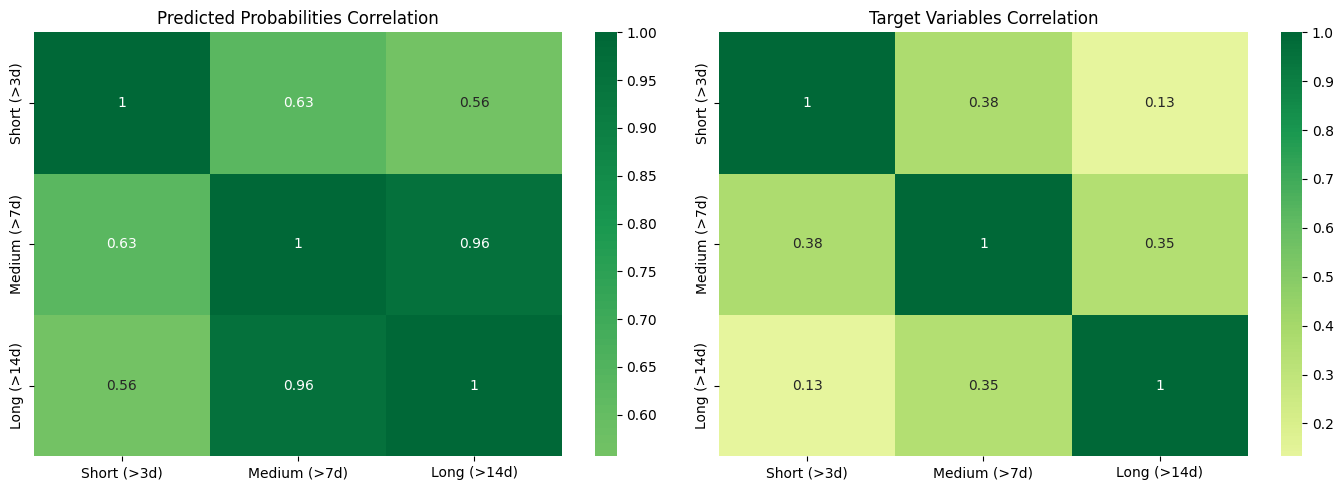


HIERARCHICAL CONSISTENCY ANALYSIS

Conditional target relationships:

P(target_medium=1 | target_long=1): 100.00%
P(target_short=1 | target_long=1): 100.00%
P(target_short=1 | target_medium=1): 100.00%

----------------------------------------------------------------------
PREDICTION HIERARCHY CONSISTENCY
----------------------------------------------------------------------
P(prob_short >= prob_medium): 98.84%
P(prob_medium >= prob_long): 99.95%


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
prob_corr = test_df[['prob_short', 'prob_medium', 'prob_long']].corr()
sns.heatmap(prob_corr, annot=True, cmap='RdYlGn', center=0, ax=ax1, 
            xticklabels=['Short (>3d)', 'Medium (>7d)', 'Long (>14d)'],
            yticklabels=['Short (>3d)', 'Medium (>7d)', 'Long (>14d)'])
ax1.set_title('Predicted Probabilities Correlation')

ax2 = axes[1]
target_corr = test_df[['target_short', 'target_medium', 'target_long']].corr()
sns.heatmap(target_corr, annot=True, cmap='RdYlGn', center=0, ax=ax2,
            xticklabels=['Short (>3d)', 'Medium (>7d)', 'Long (>14d)'],
            yticklabels=['Short (>3d)', 'Medium (>7d)', 'Long (>14d)'])
ax2.set_title('Target Variables Correlation')

plt.tight_layout()
plt.savefig('figures/correlation_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HIERARCHICAL CONSISTENCY ANALYSIS")
print("="*70)
print("\nConditional target relationships:")

long_samples = test_df[test_df['target_long'] == 1]
medium_given_long = long_samples['target_medium'].mean()
short_given_long = long_samples['target_short'].mean()

medium_samples = test_df[test_df['target_medium'] == 1]
short_given_medium = medium_samples['target_short'].mean()

print(f"\nP(target_medium=1 | target_long=1): {medium_given_long:.2%}")
print(f"P(target_short=1 | target_long=1): {short_given_long:.2%}")
print(f"P(target_short=1 | target_medium=1): {short_given_medium:.2%}")

print("\n" + "-"*70)
print("PREDICTION HIERARCHY CONSISTENCY")
print("-"*70)
consistent_pred = (test_df['prob_short'] >= test_df['prob_medium']).mean()
consistent_pred2 = (test_df['prob_medium'] >= test_df['prob_long']).mean()
print(f"P(prob_short >= prob_medium): {consistent_pred:.2%}")
print(f"P(prob_medium >= prob_long): {consistent_pred2:.2%}")

In [18]:
total_defaults_long = risk_df['target_long'].sum()
total_samples = len(risk_df)

print("="*80)
print("INTERVENTION STRATEGY ANALYSIS (target_long)")
print("="*80)

strategies = [
    ("Top 10%", 10, 10),
    ("Top 20%", 9, 10),
    ("Top 30%", 8, 10),
    ("Top 50%", 6, 10),
]

print(f"\n{'Strategy':<20} {'Reviewed':<20} {'Defaults Captured':<22} {'Precision':<15}")
print("-"*80)

for name, min_tier, max_tier in strategies:
    subset = tier_analysis.loc[min_tier:max_tier]
    reviews = subset['count'].sum()
    defaults_found = subset['defaults'].sum()
    precision = defaults_found / reviews if reviews > 0 else 0
    recall = defaults_found / total_defaults_long
    
    print(f"{name:<20} {reviews:>6,} ({reviews/total_samples*100:>5.1f}%)   "
          f"{int(defaults_found):>5} ({recall*100:>5.1f}%)          {precision*100:>5.2f}%")

print("-"*80)

print("\n" + "="*80)
print("MULTI-TARGET DECISION MATRIX")
print("="*80)
print("""
+---------------------+---------------------------+-----------+
| Action Level        | Trigger Condition         | Priority  |
+---------------------+---------------------------+-----------+
| Immediate Review    | P(long) >= 0.5            | HIGH      |
| Enhanced Monitoring | P(medium) >= 0.3          | MEDIUM    |
| Standard Follow-up  | P(short) >= 0.3           | LOW       |
| No Action Required  | All probabilities < 0.3   | NONE      |
+---------------------+---------------------------+-----------+
""")

INTERVENTION STRATEGY ANALYSIS (target_long)

Strategy             Reviewed             Defaults Captured      Precision      
--------------------------------------------------------------------------------
Top 10%               2,665 ( 10.0%)     129 ( 39.2%)           4.84%
Top 20%               5,329 ( 20.0%)     200 ( 60.8%)           3.75%
Top 30%               7,993 ( 30.0%)     242 ( 73.6%)           3.03%
Top 50%              13,322 ( 50.0%)     287 ( 87.2%)           2.15%
--------------------------------------------------------------------------------

MULTI-TARGET DECISION MATRIX

+---------------------+---------------------------+-----------+
| Action Level        | Trigger Condition         | Priority  |
+---------------------+---------------------------+-----------+
| Immediate Review    | P(long) >= 0.5            | HIGH      |
| Enhanced Monitoring | P(medium) >= 0.3          | MEDIUM    |
| Standard Follow-up  | P(short) >= 0.3           | LOW       |
| No Action Requ

ACTION CLASSIFICATION DISTRIBUTION


,action,count,defaults_short,defaults_medium,defaults_long,pct_population,long_default_rate
0,Enhanced Monitoring,26441,11037,2420,327,99.2,1.24
1,Immediate Review,39,21,15,2,0.1,5.13
2,No Action,6,0,0,0,0.0,0.00
3,Standard Follow-up,158,0,0,0,0.6,0.00


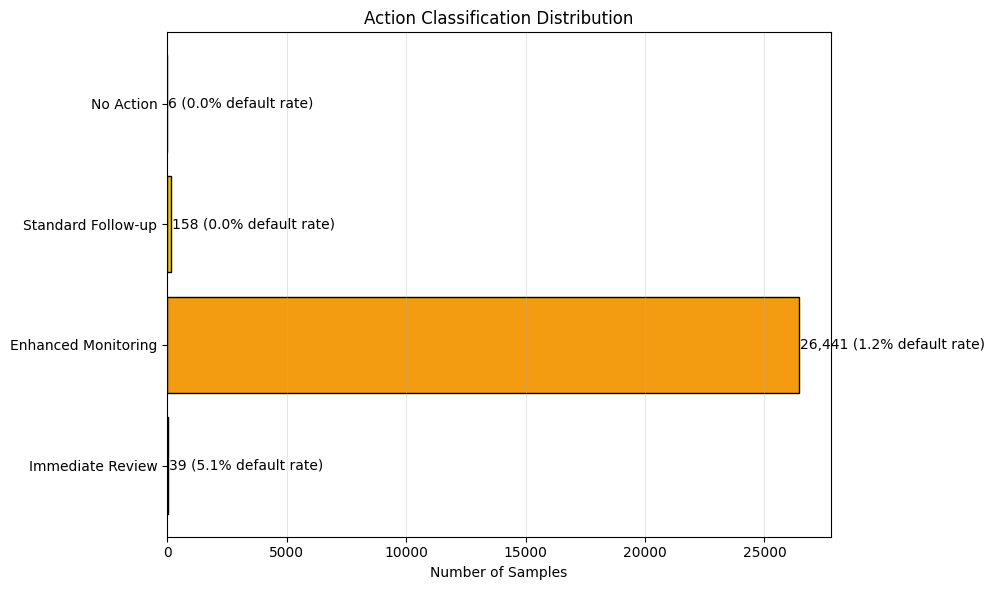

In [19]:
def classify_risk_action(row):
    if row['prob_long'] >= 0.5:
        return 'Immediate Review'
    elif row['prob_medium'] >= 0.3:
        return 'Enhanced Monitoring'
    elif row['prob_short'] >= 0.3:
        return 'Standard Follow-up'
    else:
        return 'No Action'

test_df['action'] = test_df.apply(classify_risk_action, axis=1)

action_analysis = test_df.groupby('action').agg(
    count=('target_long', 'count'),
    defaults_short=('target_short', 'sum'),
    defaults_medium=('target_medium', 'sum'),
    defaults_long=('target_long', 'sum')
).reset_index()

action_analysis['pct_population'] = (action_analysis['count'] / len(test_df) * 100).round(1)
action_analysis['long_default_rate'] = (action_analysis['defaults_long'] / action_analysis['count'] * 100).round(2)

print("="*80)
print("ACTION CLASSIFICATION DISTRIBUTION")
print("="*80)
display(action_analysis)

fig, ax = plt.subplots(figsize=(10, 6))
action_order = ['Immediate Review', 'Enhanced Monitoring', 'Standard Follow-up', 'No Action']
action_colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71']

action_counts = test_df['action'].value_counts().reindex(action_order, fill_value=0)
bars = ax.barh(action_order, action_counts.values, color=action_colors, edgecolor='black')

for i, (action, count) in enumerate(zip(action_order, action_counts.values)):
    defaults = action_analysis[action_analysis['action'] == action]['defaults_long'].values
    if len(defaults) > 0 and count > 0:
        rate = defaults[0] / count * 100
        ax.text(count + 50, i, f'{count:,} ({rate:.1f}% default rate)', va='center')

ax.set_xlabel('Number of Samples')
ax.set_title('Action Classification Distribution')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figures/action_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 5. Summary and Conclusions

In [20]:
print("="*70)
print("EXPERIMENTAL RESULTS SUMMARY")
print("="*70)

m_short = metrics_per_target['target_short']
m_medium = metrics_per_target['target_medium']
m_long = metrics_per_target['target_long']

print(f"""
+======================================================================+
|  MODEL ARCHITECTURE                                                  |
+----------------------------------------------------------------------+
|  Architecture: Transformer with RoPE + GRN Prediction Heads          |
|  Input Features: {len(dm.categorical_columns)} categorical, {len(dm.continuous_columns)} continuous                        |
|  Total Parameters: {n_params:,}                                       |
|  Temperature Scaling: {'Enabled' if model.use_temperature_scaling else 'Disabled'}                                       |
+======================================================================+
|  PERFORMANCE METRICS                                                 |
+----------------------------------------------------------------------+
|                    ROC-AUC     PR-AUC      F1-Score                  |
|  target_short:     {m_short['auc_roc']:.4f}      {m_short['auc_pr']:.4f}      {m_short['f1']:.4f}                   |
|  target_medium:    {m_medium['auc_roc']:.4f}      {m_medium['auc_pr']:.4f}      {m_medium['f1']:.4f}                   |
|  target_long:      {m_long['auc_roc']:.4f}      {m_long['auc_pr']:.4f}      {m_long['f1']:.4f}                   |
+======================================================================+
|  TEST SET STATISTICS                                                 |
+----------------------------------------------------------------------+
|  Total samples: {len(y_true):,}                                        |
|  Severe defaults (>14d): {y_true[:, 2].sum():,} ({y_true[:, 2].mean()*100:.2f}%)                         |
+======================================================================+
""")

avg_auc = (m_short['auc_roc'] + m_medium['auc_roc'] + m_long['auc_roc']) / 3

if avg_auc >= 0.85:
    assessment = "EXCELLENT - Strong discrimination capability"
elif avg_auc >= 0.75:
    assessment = "GOOD - Adequate discrimination capability"
elif avg_auc >= 0.65:
    assessment = "MODERATE - Reasonable discrimination, improvement possible"
else:
    assessment = "POOR - Significant improvement required"

print(f"Overall Assessment: {assessment}")
print(f"Mean ROC-AUC: {avg_auc:.4f}")

EXPERIMENTAL RESULTS SUMMARY

+======================================================================+
|  MODEL ARCHITECTURE                                                  |
+----------------------------------------------------------------------+
|  Architecture: Transformer with RoPE + GRN Prediction Heads          |
|  Input Features: 17 categorical, 26 continuous                        |
|  Total Parameters: 1,777,734                                       |
|  Temperature Scaling: Enabled                                       |
+======================================================================+
|  PERFORMANCE METRICS                                                 |
+----------------------------------------------------------------------+
|                    ROC-AUC     PR-AUC      F1-Score                  |
|  target_short:     0.8405      0.7732      0.7305                   |
|  target_medium:    0.8383      0.3374      0.4163                   |
|  target_long:      0.78

## 6. Individual Sequence Analysis

Detailed examination of model predictions on specific test sequences.

In [21]:
def analyze_sequence(idx, test_dataset, model, dm, device):
    x_cat, x_cont, y, length = test_dataset[idx]
    
    x_cat = x_cat.unsqueeze(0).to(device)
    x_cont = x_cont.unsqueeze(0).to(device)
    length_tensor = torch.tensor([length]).to(device)
    
    with torch.no_grad():
        logits = model(x_cat, x_cont, length_tensor, apply_temperature=True)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    targets = y.numpy()
    
    return {
        'sequence_length': length,
        'prob_short': probs[0],
        'prob_medium': probs[1],
        'prob_long': probs[2],
        'target_short': int(targets[0]),
        'target_medium': int(targets[1]),
        'target_long': int(targets[2]),
        'x_cat': x_cat.cpu(),
        'x_cont': x_cont.cpu()
    }

test_dataset = dm.test_dataset

print(f"Total test sequences: {len(test_dataset):,}")

Total test sequences: 26,644


In [22]:
test_df['original_idx'] = range(len(test_df))

threshold_long = optimal_thresholds['target_long']

true_positives = test_df[(test_df['target_long'] == 1) & (test_df['prob_long'] >= threshold_long)]
true_negatives = test_df[(test_df['target_long'] == 0) & (test_df['prob_long'] < threshold_long)]
false_positives = test_df[(test_df['target_long'] == 0) & (test_df['prob_long'] >= threshold_long)]
false_negatives = test_df[(test_df['target_long'] == 1) & (test_df['prob_long'] < threshold_long)]

print("="*70)
print("CLASSIFICATION OUTCOME DISTRIBUTION (target_long)")
print("="*70)
print(f"\nThreshold: {threshold_long:.3f}")
print(f"  True Positives:  {len(true_positives):,}")
print(f"  True Negatives:  {len(true_negatives):,}")
print(f"  False Positives: {len(false_positives):,}")
print(f"  False Negatives: {len(false_negatives):,}")

CLASSIFICATION OUTCOME DISTRIBUTION (target_long)

Threshold: 0.443
  True Positives:  81
  True Negatives:  25,190
  False Positives: 1,125
  False Negatives: 248


In [23]:
def display_sequence_analysis(case_type, df_subset, test_dataset, model, dm, device, n_samples=3):
    if len(df_subset) == 0:
        print(f"\nNo cases of type '{case_type}' found.")
        return
    
    samples = df_subset.sample(min(n_samples, len(df_subset)), random_state=42)
    
    print(f"\n{'='*70}")
    print(f"{case_type.upper()}")
    print(f"{'='*70}")
    
    for i, (_, row) in enumerate(samples.iterrows()):
        idx = row['original_idx']
        result = analyze_sequence(idx, test_dataset, model, dm, device)
        
        print(f"\nCase {i+1} (index: {idx})")
        print(f"  Sequence length: {result['sequence_length']} invoices")
        print(f"  Actual targets:")
        print(f"    Short (>3d):  {'Yes' if result['target_short'] else 'No'}")
        print(f"    Medium (>7d): {'Yes' if result['target_medium'] else 'No'}")
        print(f"    Long (>14d):  {'Yes' if result['target_long'] else 'No'}")
        print(f"  Model predictions:")
        print(f"    P(Short):  {result['prob_short']*100:6.2f}%")
        print(f"    P(Medium): {result['prob_medium']*100:6.2f}%")
        print(f"    P(Long):   {result['prob_long']*100:6.2f}%")
        
        if result['prob_long'] >= 0.5:
            action = "Immediate Review"
        elif result['prob_medium'] >= 0.3:
            action = "Enhanced Monitoring"
        elif result['prob_short'] >= 0.3:
            action = "Standard Follow-up"
        else:
            action = "No Action Required"
        
        print(f"  Recommended action: {action}")

display_sequence_analysis("True Positives", true_positives, test_dataset, model, dm, device)
display_sequence_analysis("True Negatives", true_negatives, test_dataset, model, dm, device)


TRUE POSITIVES

Case 1 (index: 21835)
  Sequence length: 1 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): Yes
    Long (>14d):  Yes
  Model predictions:
    P(Short):   61.29%
    P(Medium):  57.57%
    P(Long):    44.70%
  Recommended action: Enhanced Monitoring

Case 2 (index: 5)
  Sequence length: 6 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): Yes
    Long (>14d):  Yes
  Model predictions:
    P(Short):   56.97%
    P(Medium):  55.84%
    P(Long):    45.33%
  Recommended action: Enhanced Monitoring

Case 3 (index: 19455)
  Sequence length: 3 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): Yes
    Long (>14d):  Yes
  Model predictions:
    P(Short):   61.30%
    P(Medium):  58.81%
    P(Long):    45.73%
  Recommended action: Enhanced Monitoring

TRUE NEGATIVES

Case 1 (index: 19644)
  Sequence length: 6 invoices
  Actual targets:
    Short (>3d):  No
    Medium (>7d): No
    Long (>14d):  No
  Model predictions:
    P(Shor

In [24]:
display_sequence_analysis("False Positives", false_positives, test_dataset, model, dm, device)
display_sequence_analysis("False Negatives", false_negatives, test_dataset, model, dm, device)


FALSE POSITIVES

Case 1 (index: 26515)
  Sequence length: 1 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): Yes
    Long (>14d):  No
  Model predictions:
    P(Short):   63.14%
    P(Medium):  59.65%
    P(Long):    45.35%
  Recommended action: Enhanced Monitoring

Case 2 (index: 26558)
  Sequence length: 1 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): Yes
    Long (>14d):  No
  Model predictions:
    P(Short):   63.95%
    P(Medium):  59.13%
    P(Long):    44.71%
  Recommended action: Enhanced Monitoring

Case 3 (index: 24351)
  Sequence length: 1 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): No
    Long (>14d):  No
  Model predictions:
    P(Short):   64.81%
    P(Medium):  59.95%
    P(Long):    45.96%
  Recommended action: Enhanced Monitoring

FALSE NEGATIVES

Case 1 (index: 4300)
  Sequence length: 1 invoices
  Actual targets:
    Short (>3d):  Yes
    Medium (>7d): Yes
    Long (>14d):  Yes
  Model predictions:
    P(

/tmp/ipykernel_15811/3474463391.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Short\n(>3d)', 'Medium\n(>7d)', 'Long\n(>14d)'],
/tmp/ipykernel_15811/3474463391.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Short\n(>3d)', 'Medium\n(>7d)', 'Long\n(>14d)'],
/tmp/ipykernel_15811/3474463391.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Short\n(>3d)', 'Medium\n(>7d)', 'Long\n(>14d)'],
/tmp/ipykernel_15811/3474463391.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() h

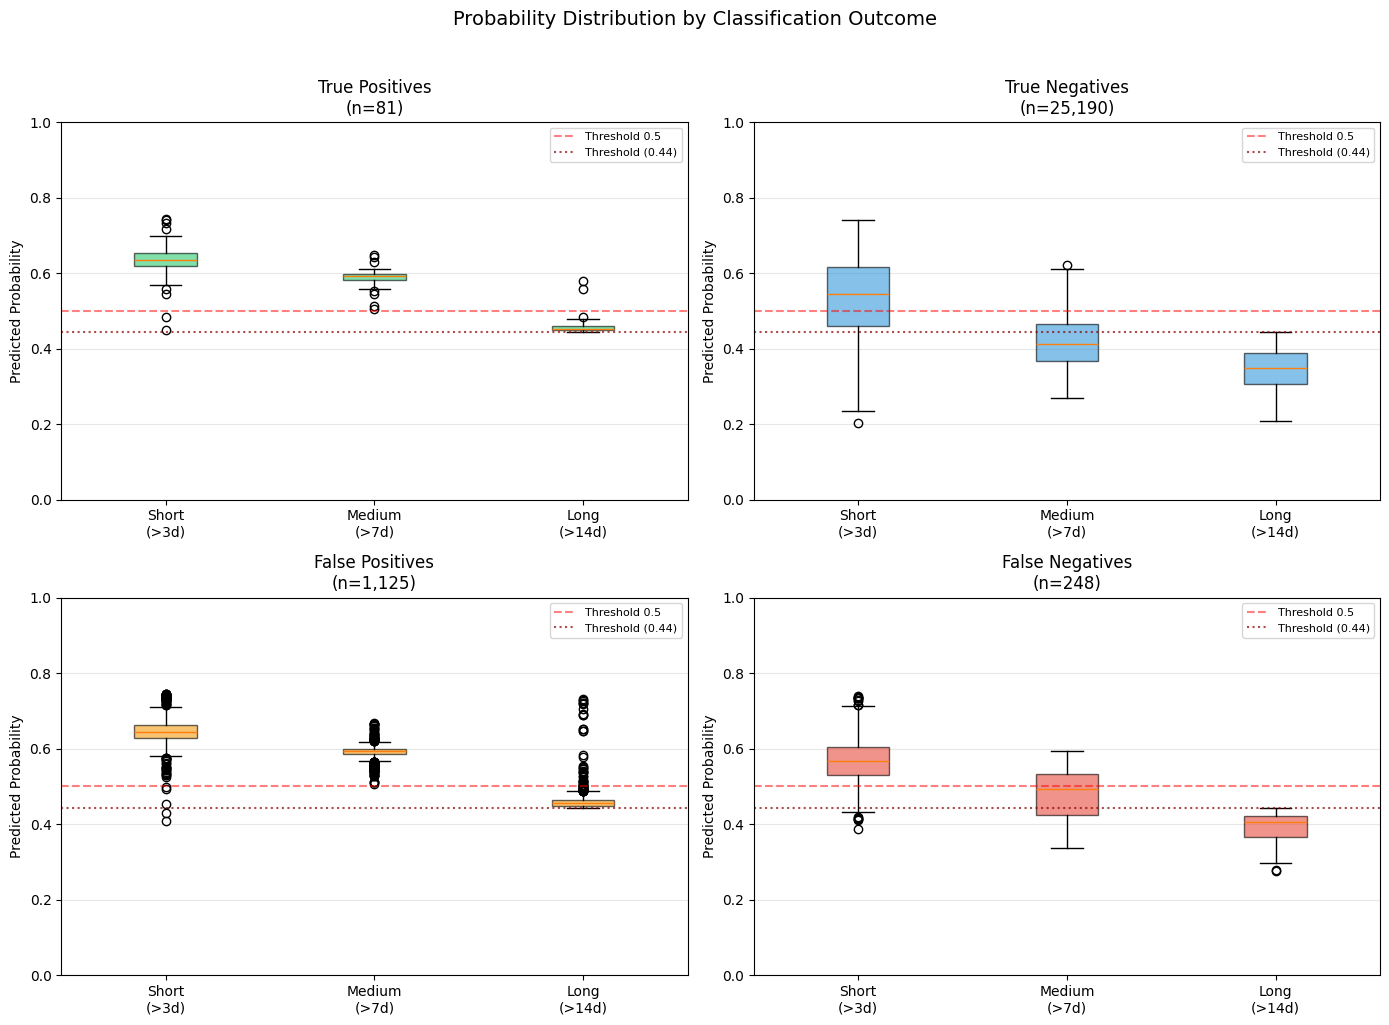

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categories = [
    ("True Positives", true_positives, '#2ecc71'),
    ("True Negatives", true_negatives, '#3498db'),
    ("False Positives", false_positives, '#f39c12'),
    ("False Negatives", false_negatives, '#e74c3c')
]

for ax, (cat_name, df_cat, color) in zip(axes.flatten(), categories):
    if len(df_cat) > 0:
        data_to_plot = [df_cat['prob_short'], df_cat['prob_medium'], df_cat['prob_long']]
        bp = ax.boxplot(data_to_plot, labels=['Short\n(>3d)', 'Medium\n(>7d)', 'Long\n(>14d)'],
                       patch_artist=True)
        
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold 0.5')
        ax.axhline(y=threshold_long, color='darkred', linestyle=':', alpha=0.7, 
                   label=f'Threshold ({threshold_long:.2f})')
        
        ax.set_ylabel('Predicted Probability')
        ax.set_title(f'{cat_name}\n(n={len(df_cat):,})')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(loc='upper right', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'No cases', ha='center', va='center', fontsize=14)
        ax.set_title(f'{cat_name}\n(n=0)')

plt.suptitle('Probability Distribution by Classification Outcome', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('figures/probability_by_outcome.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
def analyze_specific_sequences(indices, test_dataset, model, dm, device):
    print("="*80)
    print("DETAILED SEQUENCE ANALYSIS")
    print("="*80)
    
    results = []
    for idx in indices:
        if idx >= len(test_dataset):
            print(f"\nIndex {idx} out of range (max: {len(test_dataset)-1})")
            continue
            
        result = analyze_sequence(idx, test_dataset, model, dm, device)
        results.append(result)
        
        pred_long = 1 if result['prob_long'] >= threshold_long else 0
        correct = "CORRECT" if pred_long == result['target_long'] else "INCORRECT"
        
        print(f"\nSequence #{idx}")
        print(f"  Length: {result['sequence_length']} invoices | Classification: {correct}")
        print(f"  Target     | Short: {result['target_short']}  | Medium: {result['target_medium']}  | Long: {result['target_long']}")
        print(f"  Prediction | {result['prob_short']*100:5.1f}%   | {result['prob_medium']*100:5.1f}%    | {result['prob_long']*100:5.1f}%")
    
    return results

sample_indices = []

if len(true_positives) > 0:
    high_conf_tp = true_positives.nlargest(2, 'prob_long')['original_idx'].tolist()
    sample_indices.extend(high_conf_tp)

if len(false_negatives) > 0:
    fn_samples = false_negatives.sample(min(2, len(false_negatives)), random_state=42)['original_idx'].tolist()
    sample_indices.extend(fn_samples)

if len(true_negatives) > 0:
    low_prob_tn = true_negatives.nsmallest(2, 'prob_long')['original_idx'].tolist()
    sample_indices.extend(low_prob_tn)

results = analyze_specific_sequences(sample_indices, test_dataset, model, dm, device)

DETAILED SEQUENCE ANALYSIS

Sequence #6200
  Length: 31 invoices | Classification: CORRECT
  Target     | Short: 1  | Medium: 1  | Long: 1
  Prediction |  74.3%   |  64.2%    |  57.9%

Sequence #25554
  Length: 1 invoices | Classification: CORRECT
  Target     | Short: 1  | Medium: 1  | Long: 1
  Prediction |  69.2%   |  64.7%    |  55.7%

Sequence #4300
  Length: 1 invoices | Classification: INCORRECT
  Target     | Short: 1  | Medium: 1  | Long: 1
  Prediction |  56.5%   |  45.9%    |  39.8%

Sequence #77
  Length: 2 invoices | Classification: INCORRECT
  Target     | Short: 1  | Medium: 1  | Long: 1
  Prediction |  53.2%   |  48.0%    |  40.7%

Sequence #14692
  Length: 13 invoices | Classification: CORRECT
  Target     | Short: 0  | Medium: 0  | Long: 0
  Prediction |  28.9%   |  27.0%    |  20.8%

Sequence #3791
  Length: 50 invoices | Classification: CORRECT
  Target     | Short: 0  | Medium: 0  | Long: 0
  Prediction |  39.4%   |  29.7%    |  21.2%


In [27]:
print("="*80)
print("PERFORMANCE ANALYSIS BY SEQUENCE LENGTH EXTREMES")
print("="*80)

short_seqs = test_df[test_df['seq_length'] <= 2]
long_seqs = test_df[test_df['seq_length'] > 20]

print(f"\nShort sequences (1-2 invoices): {len(short_seqs):,} samples")
if len(short_seqs) > 0:
    print(f"  Default rate (long): {short_seqs['target_long'].mean()*100:.2f}%")
    print(f"  Mean probability (long): {short_seqs['prob_long'].mean()*100:.2f}%")
    if len(short_seqs[short_seqs['target_long'] == 1]) > 0:
        auc_short = roc_auc_score(short_seqs['target_long'], short_seqs['prob_long'])
        print(f"  ROC-AUC: {auc_short:.4f}")

print(f"\nLong sequences (>20 invoices): {len(long_seqs):,} samples")
if len(long_seqs) > 0:
    print(f"  Default rate (long): {long_seqs['target_long'].mean()*100:.2f}%")
    print(f"  Mean probability (long): {long_seqs['prob_long'].mean()*100:.2f}%")
    if len(long_seqs[long_seqs['target_long'] == 1]) > 0:
        auc_long = roc_auc_score(long_seqs['target_long'], long_seqs['prob_long'])
        print(f"  ROC-AUC: {auc_long:.4f}")

print("\n" + "-"*80)
print("Sample short sequences:")
if len(short_seqs) > 0:
    for idx in short_seqs.sample(min(3, len(short_seqs)), random_state=123)['original_idx']:
        result = analyze_sequence(idx, test_dataset, model, dm, device)
        status = "DEFAULT" if result['target_long'] else "OK"
        pred = f"{result['prob_long']*100:.1f}%"
        print(f"  Seq #{idx}: {result['sequence_length']} invoices | Actual: {status:7} | P(Long): {pred}")

PERFORMANCE ANALYSIS BY SEQUENCE LENGTH EXTREMES

Short sequences (1-2 invoices): 3,547 samples
  Default rate (long): 3.52%
  Mean probability (long): 42.24%
  ROC-AUC: 0.6357

Long sequences (>20 invoices): 10,416 samples
  Default rate (long): 0.39%
  Mean probability (long): 30.99%
  ROC-AUC: 0.7659

--------------------------------------------------------------------------------
Sample short sequences:
  Seq #15254: 1 invoices | Actual: OK      | P(Long): 37.8%
  Seq #9420: 2 invoices | Actual: OK      | P(Long): 38.5%
  Seq #19602: 2 invoices | Actual: OK      | P(Long): 42.0%


In [28]:
sequence_index = 0

if sequence_index < len(test_dataset):
    result = analyze_sequence(sequence_index, test_dataset, model, dm, device)
    
    print("="*70)
    print(f"SEQUENCE ANALYSIS: #{sequence_index}")
    print("="*70)
    
    pred_long = result['prob_long'] >= threshold_long
    actual_long = result['target_long'] == 1
    
    if pred_long and actual_long:
        status = "TRUE POSITIVE"
    elif not pred_long and not actual_long:
        status = "TRUE NEGATIVE"
    elif pred_long and not actual_long:
        status = "FALSE POSITIVE"
    else:
        status = "FALSE NEGATIVE"
    
    print(f"\nClassification: {status}")
    print(f"Sequence length: {result['sequence_length']} invoices")
    
    print(f"\n{'Target':<15} {'Actual':<10} {'Predicted':<12} {'Threshold':<10}")
    print("-"*50)
    
    for target, prob, name, thresh in [
        (result['target_short'], result['prob_short'], 'Short (>3d)', 0.3),
        (result['target_medium'], result['prob_medium'], 'Medium (>7d)', 0.3),
        (result['target_long'], result['prob_long'], 'Long (>14d)', threshold_long)
    ]:
        target_str = "Yes" if target else "No"
        prob_str = f"{prob*100:.2f}%"
        thresh_str = f"{thresh:.2f}"
        print(f"{name:<15} {target_str:<10} {prob_str:<12} {thresh_str:<10}")
    
    print(f"\nHierarchical consistency:")
    if result['prob_short'] >= result['prob_medium'] >= result['prob_long']:
        print("  Predictions respect hierarchy (short >= medium >= long)")
    else:
        print("  Predictions violate expected hierarchy")
        print(f"  Short: {result['prob_short']:.4f} | Medium: {result['prob_medium']:.4f} | Long: {result['prob_long']:.4f}")
else:
    print(f"Index {sequence_index} out of range (max: {len(test_dataset)-1})")

SEQUENCE ANALYSIS: #0

Classification: FALSE NEGATIVE
Sequence length: 1 invoices

Target          Actual     Predicted    Threshold 
--------------------------------------------------
Short (>3d)     Yes        62.39%       0.30      
Medium (>7d)    Yes        55.88%       0.30      
Long (>14d)     Yes        44.05%       0.44      

Hierarchical consistency:
  Predictions respect hierarchy (short >= medium >= long)


## 7. Temporal Prediction Evolution

Analysis of how model predictions evolve as additional invoices are incorporated into the user's historical sequence.

In [29]:
original_df = pd.read_parquet(data_path)

for col in dm.categorical_columns:
    if col in dm.label_encoders:
        original_df[col] = original_df[col].astype(str)
        original_df[col] = dm.label_encoders[col].transform(original_df[col]) + 1

delay_col = config.columns.delay_col
cont_cols_no_delay = [c for c in dm.continuous_columns if c != delay_col]
original_df[cont_cols_no_delay] = dm.scaler.transform(original_df[cont_cols_no_delay])

user_col = config.columns.user_id_col
contract_col = config.columns.contract_id_col
order_col = config.columns.order_col
due_date_col = config.columns.due_date_col

sort_columns = [user_col, contract_col, order_col] if order_col in original_df.columns else [user_col, contract_col, due_date_col]
original_df = original_df.sort_values(sort_columns).reset_index(drop=True)

print(f"Data loaded: {len(original_df):,} invoices")
print(f"Delay column: {delay_col}")
print(f"Target columns: {dm.target_columns}")

ValueError: y contains previously unseen labels: 'Trimestral Promoção'

In [30]:
def analyze_full_sequence_evolution(user_contract_id, original_df, dm, model, device, max_seq_len=50):
    group_cols = config.columns.group_cols
    delay_col = config.columns.delay_col
    
    if isinstance(group_cols, list):
        mask = (original_df[group_cols[0]] == user_contract_id[0])
        for i, col in enumerate(group_cols[1:], 1):
            mask &= (original_df[col] == user_contract_id[i])
        user_data = original_df[mask].copy()
    else:
        user_data = original_df[original_df[group_cols] == user_contract_id].copy()
    
    user_data = user_data.reset_index(drop=True)
    n_invoices = len(user_data)
    
    if n_invoices < 2:
        print(f"Insufficient invoices: {n_invoices}. Minimum required: 2")
        return None
    
    results = []
    
    for target_pos in range(1, n_invoices):
        history_start = max(0, target_pos - max_seq_len)
        history_end = target_pos
        
        history_cat = user_data.iloc[history_start:history_end][dm.categorical_columns].values
        history_cont = user_data.iloc[history_start:history_end][dm.continuous_columns].values
        
        target_row = user_data.iloc[target_pos]
        real_delay = target_row[delay_col]
        real_targets = target_row[dm.target_columns].values
        
        x_cat = torch.tensor(history_cat, dtype=torch.long).unsqueeze(0).to(device)
        x_cont = torch.tensor(history_cont, dtype=torch.float32).unsqueeze(0).to(device)
        length = torch.tensor([history_end - history_start]).to(device)
        
        with torch.no_grad():
            logits = model(x_cat, x_cont, length, apply_temperature=True)
            probs = torch.sigmoid(logits).cpu().numpy()[0]
        
        results.append({
            'invoice_num': target_pos + 1,
            'history_length': history_end - history_start,
            'actual_delay': real_delay,
            'target_short': int(real_targets[0]),
            'target_medium': int(real_targets[1]),
            'target_long': int(real_targets[2]),
            'prob_short': probs[0],
            'prob_medium': probs[1],
            'prob_long': probs[2]
        })
    
    return pd.DataFrame(results), user_data

test_indices_info = dm.test_indices

print(f"Total test sequences: {len(test_indices_info):,}")
print(f"Index example: start={test_indices_info[0][0]}, end={test_indices_info[0][1]}, target={test_indices_info[0][2]}")

Total test sequences: 26,644
Index example: start=0, end=1, target=1


In [31]:
group_cols = config.columns.group_cols
delay_col = config.columns.delay_col

invoice_counts = original_df.groupby(group_cols).size().reset_index(name='n_invoices')
invoice_counts = invoice_counts[invoice_counts['n_invoices'] >= 5]

groups_with_long_default = original_df[original_df['target_long'] == 1].groupby(group_cols).size().reset_index(name='n_long_defaults')

interesting_groups = invoice_counts.merge(groups_with_long_default, on=group_cols, how='left')
interesting_groups['n_long_defaults'] = interesting_groups['n_long_defaults'].fillna(0).astype(int)

interesting_groups = interesting_groups.sort_values(['n_long_defaults', 'n_invoices'], ascending=[False, False])

print("="*80)
print("CANDIDATE GROUPS FOR TEMPORAL ANALYSIS")
print("="*80)
print(f"\nGroups with >= 5 invoices: {len(interesting_groups):,}")
print(f"Groups with severe defaults: {(interesting_groups['n_long_defaults'] > 0).sum():,}")
print("\nTop 10 groups by default count:")
display(interesting_groups.head(10))

CANDIDATE GROUPS FOR TEMPORAL ANALYSIS

Groups with >= 5 invoices: 237,402
Groups with severe defaults: 45,357

Top 10 groups by default count:


,usuarioId,locacaoId,n_invoices,n_long_defaults
15803,179866,1589049,104,103
1859,44102,513165,103,103
4272,84612,625444,103,103
4998,94365,678565,103,103
747,15000,512575,103,102
1270,22651,530478,103,102
1748,42062,509875,103,102
2251,52131,535436,103,102
3633,76367,591056,103,102
101287,844361,4058058,103,102


In [32]:
selected_group = tuple(interesting_groups[interesting_groups['n_long_defaults'] > 0].iloc[0][group_cols].values)
print(f"Selected group: {selected_group}")

evolution_df, user_data = analyze_full_sequence_evolution(
    selected_group, original_df, dm, model, device, 
    max_seq_len=config.model.max_seq_len
)

print(f"\n{'='*90}")
print(f"TEMPORAL PREDICTION EVOLUTION - Group: {selected_group}")
print(f"{'='*90}")
print(f"Total invoices: {len(user_data)}")
print(f"Predictions generated: {len(evolution_df)}")

print(f"\n{'Invoice':<10} {'History':<10} {'Delay':<10} {'Target':<15} {'P(Short)':<12} {'P(Med)':<12} {'P(Long)':<12} {'Result':<10}")
print("-"*100)

for _, row in evolution_df.iterrows():
    target_str = f"S:{row['target_short']} M:{row['target_medium']} L:{row['target_long']}"
    
    pred_long = row['prob_long'] >= threshold_long
    actual_long = row['target_long'] == 1
    if pred_long and actual_long:
        status = "TP"
    elif not pred_long and not actual_long:
        status = "TN"
    elif pred_long and not actual_long:
        status = "FP"
    else:
        status = "FN"
    
    delay_str = f"{row['actual_delay']:.0f}d" if pd.notna(row['actual_delay']) else "N/A"
    
    print(f"#{row['invoice_num']:<9} {row['history_length']:<10} {delay_str:<10} {target_str:<15} "
          f"{row['prob_short']*100:>6.1f}%     {row['prob_medium']*100:>6.1f}%     {row['prob_long']*100:>6.1f}%     {status}")

Selected group: (np.int64(179866), np.int64(1589049))


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

NameError: name 'evolution_df' is not defined

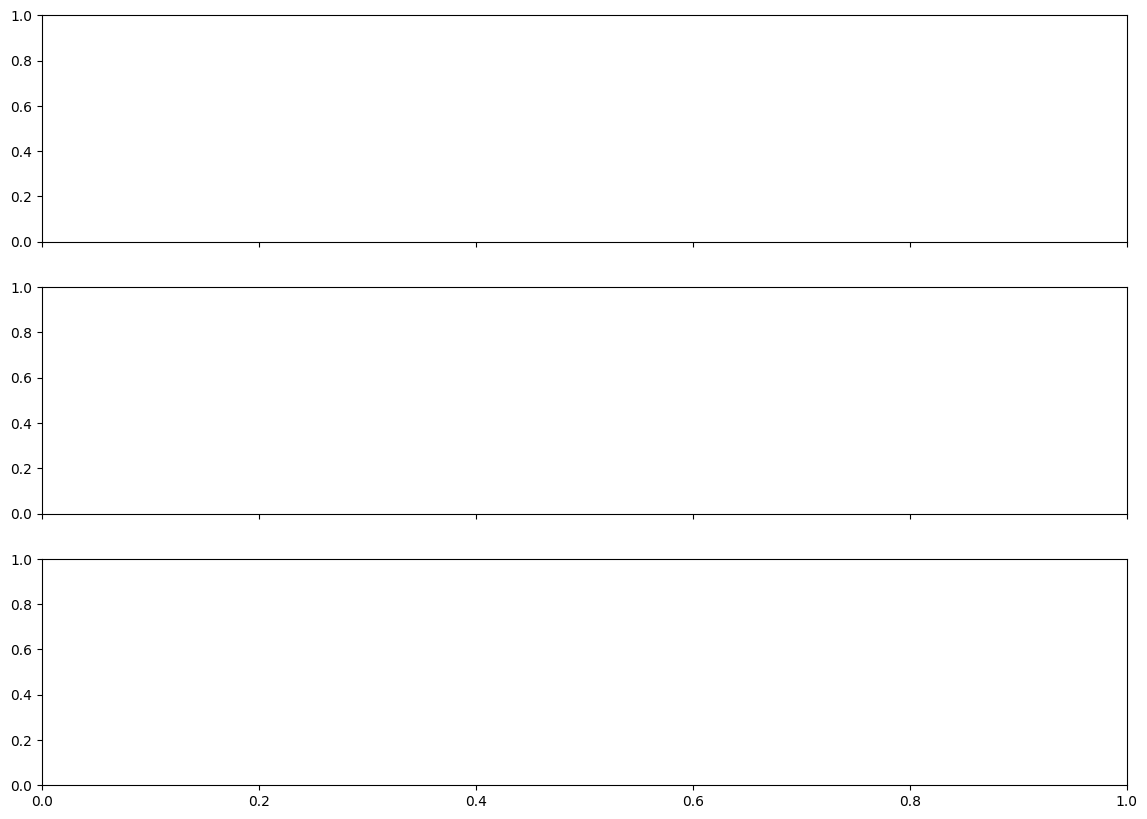

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

x = evolution_df['invoice_num'].values

ax1 = axes[0]
delays = evolution_df['actual_delay'].values
colors_delay = ['green' if d <= 3 else 'orange' if d <= 7 else 'red' if d <= 14 else 'darkred' for d in delays]
bars = ax1.bar(x, delays, color=colors_delay, edgecolor='black', alpha=0.7)
ax1.axhline(y=3, color='green', linestyle='--', alpha=0.5, label='3 days')
ax1.axhline(y=7, color='orange', linestyle='--', alpha=0.5, label='7 days')
ax1.axhline(y=14, color='red', linestyle='--', alpha=0.5, label='14 days')
ax1.set_ylabel('Actual Delay (days)')
ax1.set_title(f'Temporal Evolution - Group: {selected_group}')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[1]
ax2.plot(x, evolution_df['prob_short']*100, 'g-o', label='P(Short >3d)', linewidth=2, markersize=4)
ax2.plot(x, evolution_df['prob_medium']*100, 'orange', marker='s', label='P(Medium >7d)', linewidth=2, markersize=4)
ax2.plot(x, evolution_df['prob_long']*100, 'r-^', label='P(Long >14d)', linewidth=2, markersize=4)
ax2.axhline(y=threshold_long*100, color='darkred', linestyle=':', alpha=0.7, label=f'Threshold ({threshold_long*100:.0f}%)')
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Probability (%)')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.bar(x, evolution_df['target_short'], color='green', alpha=0.6, label='Short (>3d)')
ax3.bar(x, evolution_df['target_medium'], bottom=evolution_df['target_short'], color='orange', alpha=0.6, label='Medium (>7d)')
ax3.bar(x, evolution_df['target_long'], bottom=evolution_df['target_short']+evolution_df['target_medium'], color='red', alpha=0.6, label='Long (>14d)')
ax3.set_ylabel('Target')
ax3.set_xlabel('Invoice Number')
ax3.set_yticks([0, 1, 2, 3])
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/temporal_evolution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
GROUP_INDEX = 0

grupos_com_defaults = interesting_groups[interesting_groups['n_long_defaults'] > 0]

if GROUP_INDEX < len(grupos_com_defaults):
    selected = tuple(grupos_com_defaults.iloc[GROUP_INDEX][group_cols].values)
    n_invoices = grupos_com_defaults.iloc[GROUP_INDEX]['n_invoices']
    n_defaults = grupos_com_defaults.iloc[GROUP_INDEX]['n_long_defaults']
    
    print(f"Analyzing group #{GROUP_INDEX}: {selected}")
    print(f"Total invoices: {n_invoices}, Severe defaults: {n_defaults}")
    
    evo_df, usr_data = analyze_full_sequence_evolution(selected, original_df, dm, model, device, max_seq_len=config.model.max_seq_len)
    
    if evo_df is not None:
        fig, ax = plt.subplots(figsize=(16, 6))
        
        x = evo_df['invoice_num'].values
        
        max_delay = max(evo_df['actual_delay'].max(), 20)
        ax2 = ax.twinx()
        bars = ax2.bar(x, evo_df['actual_delay'], alpha=0.3, color='gray', label='Actual Delay')
        ax2.set_ylabel('Actual Delay (days)', color='gray')
        ax2.set_ylim(0, max_delay * 1.2)
        ax2.axhline(y=3, color='green', linestyle=':', alpha=0.3)
        ax2.axhline(y=7, color='orange', linestyle=':', alpha=0.3)
        ax2.axhline(y=14, color='red', linestyle=':', alpha=0.3)
        
        ax.plot(x, evo_df['prob_short']*100, 'g-o', label='P(>3d)', linewidth=2, markersize=6)
        ax.plot(x, evo_df['prob_medium']*100, 'orange', marker='s', linestyle='-', label='P(>7d)', linewidth=2, markersize=6)
        ax.plot(x, evo_df['prob_long']*100, 'r-^', label='P(>14d)', linewidth=2, markersize=6)
        
        default_positions = evo_df[evo_df['target_long'] == 1]['invoice_num'].values
        for dp in default_positions:
            ax.axvline(x=dp, color='red', linestyle='--', alpha=0.5, linewidth=2)
        
        ax.set_xlabel('Invoice Number')
        ax.set_ylabel('Predicted Probability (%)')
        ax.set_ylim(0, 100)
        ax.axhline(y=threshold_long*100, color='darkred', linestyle=':', label=f'Threshold ({threshold_long*100:.0f}%)')
        ax.legend(loc='upper left')
        ax.set_title(f'Prediction Evolution - Group: {selected}\n(Vertical red lines indicate actual defaults)')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(x)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n{'='*100}")
        print("DETAILED EVOLUTION:")
        print(f"{'='*100}")
        for _, row in evo_df.iterrows():
            pred_status = "HIGH RISK" if row['prob_long'] >= threshold_long else "LOW RISK"
            print(f"Invoice #{row['invoice_num']:2d} | History: {row['history_length']:2d} invoices | "
                  f"Delay: {row['actual_delay']:5.0f}d | "
                  f"P(Long): {row['prob_long']*100:5.1f}% [{pred_status}]")
else:
    print(f"Invalid index {GROUP_INDEX}. Maximum: {len(grupos_com_defaults)-1}")

In [ ]:
def show_detailed_sequence_view(group_id, original_df, dm, model, device, max_show=10):
    group_cols = config.columns.group_cols
    delay_col = config.columns.delay_col
    
    if isinstance(group_cols, list):
        mask = (original_df[group_cols[0]] == group_id[0])
        for i, col in enumerate(group_cols[1:], 1):
            mask &= (original_df[col] == group_id[i])
        user_data = original_df[mask].copy()
    else:
        user_data = original_df[original_df[group_cols] == group_id].copy()
    
    user_data = user_data.reset_index(drop=True)
    n_invoices = len(user_data)
    
    print("="*100)
    print(f"DETAILED ANALYSIS: Group {group_id}")
    print("="*100)
    print(f"\nINVOICE HISTORY:")
    print("-"*100)
    
    for i in range(min(n_invoices, 30)):
        row = user_data.iloc[i]
        delay = row[delay_col]
        targets = row[dm.target_columns].values
        
        if delay <= 0:
            status = "On time"
        elif delay <= 3:
            status = "Mild (<=3d)"
        elif delay <= 7:
            status = "Moderate (3-7d)"
        elif delay <= 14:
            status = "Significant (7-14d)"
        else:
            status = "SEVERE (>14d)"
        
        print(f"  Invoice #{i+1:2d}: Delay = {delay:6.1f} days | {status} | Targets: S={int(targets[0])} M={int(targets[1])} L={int(targets[2])}")
    
    if n_invoices > 30:
        print(f"  ... (+{n_invoices - 30} invoices omitted)")
    
    print(f"\n{'='*100}")
    print("MODEL PREDICTION EVOLUTION:")
    print("="*100)
    print("-"*100)
    
    for target_pos in range(1, min(n_invoices, max_show + 1)):
        history_start = max(0, target_pos - config.model.max_seq_len)
        history_end = target_pos
        
        history_cat = user_data.iloc[history_start:history_end][dm.categorical_columns].values
        history_cont = user_data.iloc[history_start:history_end][dm.continuous_columns].values
        
        target_row = user_data.iloc[target_pos]
        real_delay = target_row[delay_col]
        real_targets = target_row[dm.target_columns].values
        
        x_cat = torch.tensor(history_cat, dtype=torch.long).unsqueeze(0).to(device)
        x_cont = torch.tensor(history_cont, dtype=torch.float32).unsqueeze(0).to(device)
        length = torch.tensor([history_end - history_start]).to(device)
        
        with torch.no_grad():
            logits = model(x_cat, x_cont, length, apply_temperature=True)
            probs = torch.sigmoid(logits).cpu().numpy()[0]
        
        history_delays = user_data.iloc[history_start:history_end][delay_col].values
        delay_summary = " -> ".join([f"{d:.0f}d" for d in history_delays[-5:]])
        if len(history_delays) > 5:
            delay_summary = f"... -> {delay_summary}"
        
        print(f"\nPrediction for Invoice #{target_pos + 1}")
        print(f"  Visible history: {history_end - history_start} invoices")
        print(f"  Recent delays: [{delay_summary}]")
        print(f"  Actual delay: {real_delay:.0f} days")
        print(f"  Targets: Short={int(real_targets[0])} Medium={int(real_targets[1])} Long={int(real_targets[2])}")
        print(f"  Model predictions:")
        print(f"    P(>3 days):  {probs[0]*100:6.2f}%")
        print(f"    P(>7 days):  {probs[1]*100:6.2f}%")
        print(f"    P(>14 days): {probs[2]*100:6.2f}%")
        
        pred_long = probs[2] >= threshold_long
        actual_long = real_targets[2] == 1
        if pred_long == actual_long:
            print(f"  Classification: CORRECT")
        else:
            print(f"  Classification: INCORRECT ({'False Alarm' if pred_long else 'Missed Default'})")

show_detailed_sequence_view(selected_group, original_df, dm, model, device, max_show=8)